In [1]:
import networkx as nx
import numpy as np
from spenet import slq_spenet, ste_spenet, exact_spenet
from utils import load_graph, rodger_graphs, weighted_graphs, unweighted_graphs, relative_error
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
step = 10
nv = 100
avg = 10

# 各グラフについて k=4 のとき

In [3]:
k = 4

In [10]:
def add_relative_error(df, G, now_id):
    gtypes = ["normalized_laplacian", "laplacian", "adjacency"]
    for gtype in gtypes:
        if gtype == "normalized_laplacian":
            M = nx.normalized_laplacian_matrix(G)
        elif gtype == "laplacian":
            M = nx.laplacian_matrix(G)
        elif gtype == "adjacency":
            M = nx.adjacency_matrix(G)
        
        errors = []
        exact = exact_spenet(M, k, method="prod")
        for seed in range(avg):
            #ste = ste_spenet(M, k, nv=nv, seed=seed)
            slq = slq_spenet(M, k, step=step, nv=nv, seed=seed)
            errors.append(relative_error(slq, exact))
        errors = np.array(errors)    
        df = df.append({"id":now_id, "relative_error":errors.mean(), "k":k, "matrix":gtype},ignore_index=True)
    return df

df = pd.DataFrame(columns=["id", "relative_error", "k", "matrix"])

now_id = 0
# unweighted_graphs
is_weighted = False
for path in unweighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1

"""
# rodger_graphs
is_weighted = False
for path in rodger_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1
"""

# weighted_graphs
is_weighted = True
for path in weighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1




path:data/networkrepository/bio/bio-celegans/bio-celegans.mtx, n:453, m:2025
path:data/networkrepository/bio/bio-celegans-dir/bio-celegans-dir.edges, n:453, m:2040
path:data/networkrepository/bio/bio-diseasome/bio-diseasome.mtx, n:516, m:1188
path:data/networkrepository/cheminformatics/ENZYMES_g295/ENZYMES_g295.edges, n:123, m:139
path:data/networkrepository/cheminformatics/ENZYMES_g296/ENZYMES_g296.edges, n:125, m:141
path:data/networkrepository/cheminformatics/ENZYMES_g297/ENZYMES_g297.edges, n:121, m:149
path:data/networkrepository/interaction/ia-crime-moreno/ia-crime-moreno.edges, n:829, m:1475
path:data/networkrepository/interaction/ia-email-univ/ia-email-univ.mtx, n:1133, m:5451
path:data/networkrepository/interaction/ia-enron-only/ia-enron-only.mtx, n:143, m:623
path:data/networkrepository/interaction/ia-fb-messages/ia-fb-messages.mtx, n:1266, m:6451
path:data/networkrepository/interaction/ia-infect-dublin/ia-infect-dublin.mtx, n:410, m:2765
path:data/networkrepository/interacti

In [11]:
df.head()

,id,relative_error,k,matrix
0,0,0.003762,4,normalized_laplacian
1,0,0.091421,4,laplacian
2,0,0.101652,4,adjacency
3,1,0.004895,4,normalized_laplacian
4,1,0.125919,4,laplacian


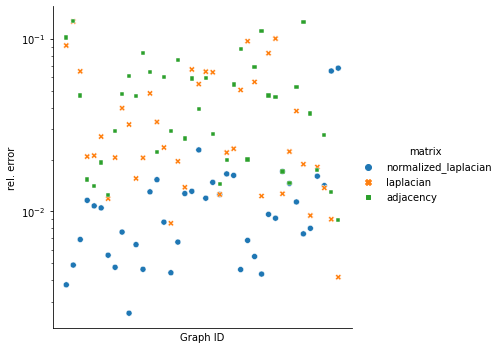

In [12]:
k = 4
tmp_df = df[df["k"]==k]
ax = sns.relplot(
    data=tmp_df,
    x="id", y="relative_error",
    hue="matrix", style="matrix"
)
ax.set(xlabel="Graph ID",ylabel="rel. error", yscale="log", xticks=[]) #
plt.savefig(f'plot/plot_each_graph_k{k}.png')
plt.show()

# k=4.5 のとき

In [13]:
k=4.5

In [26]:
def add_relative_error(df, G, now_id):
    gtypes = ["normalized_laplacian", "laplacian"]
    for gtype in gtypes:
        if gtype == "normalized_laplacian":
            M = nx.normalized_laplacian_matrix(G)
        elif gtype == "laplacian":
            M = nx.laplacian_matrix(G)
        elif gtype == "adjacency":
            M = nx.adjacency_matrix(G)
        
        errors = []
        exact = exact_spenet(M, k, method="eig")
        for seed in range(avg):
            #ste = ste_spenet(M, k, nv=nv, seed=seed)
            slq = slq_spenet(M, k, step=step, nv=nv, seed=seed)
            errors.append(relative_error(slq, exact))
        errors = np.array(errors)    
        df = df.append({"id":now_id, "relative_error":errors.mean(), "k":k, "matrix":gtype},ignore_index=True)
    return df

df = pd.DataFrame(columns=["id", "relative_error", "k", "matrix"])

now_id = 0
# unweighted_graphs
is_weighted = False
for path in unweighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1

"""
# rodger_graphs
is_weighted = False
for path in rodger_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1
"""

# weighted_graphs
is_weighted = True
for path in weighted_graphs:
    G = load_graph(path, is_weighted)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    print(f"now_id:{now_id}, path:{path}, n:{n}, m:{m}")
    df = add_relative_error(df, G, now_id)
    now_id += 1


now_id:0, path:data/networkrepository/bio/bio-celegans/bio-celegans.mtx, n:453, m:2025
now_id:1, path:data/networkrepository/bio/bio-celegans-dir/bio-celegans-dir.edges, n:453, m:2040
now_id:2, path:data/networkrepository/bio/bio-diseasome/bio-diseasome.mtx, n:516, m:1188
now_id:3, path:data/networkrepository/cheminformatics/ENZYMES_g295/ENZYMES_g295.edges, n:123, m:139
now_id:4, path:data/networkrepository/cheminformatics/ENZYMES_g296/ENZYMES_g296.edges, n:125, m:141
now_id:5, path:data/networkrepository/cheminformatics/ENZYMES_g297/ENZYMES_g297.edges, n:121, m:149
now_id:6, path:data/networkrepository/interaction/ia-crime-moreno/ia-crime-moreno.edges, n:829, m:1475
now_id:7, path:data/networkrepository/interaction/ia-email-univ/ia-email-univ.mtx, n:1133, m:5451
now_id:8, path:data/networkrepository/interaction/ia-enron-only/ia-enron-only.mtx, n:143, m:623
now_id:9, path:data/networkrepository/interaction/ia-fb-messages/ia-fb-messages.mtx, n:1266, m:6451
now_id:10, path:data/networkre

/Users/murakaminaoki/git/research/SPENet/spenet.py:52: RuntimeWarning: invalid value encountered in power
  return lambda x: np.power(x, k)


now_id:21, path:data/networkrepository/miscellaneous/GD98_b/GD98_b.mtx, n:121, m:132
now_id:22, path:data/networkrepository/miscellaneous/GD98_c/GD98_c.mtx, n:112, m:168
now_id:23, path:data/networkrepository/miscellaneous/GD99_c/GD99_c.mtx, n:105, m:120
now_id:24, path:data/networkrepository/miscellaneous/gent113/gent113.mtx, n:113, m:639
now_id:25, path:data/networkrepository/bio/bio-CE-GT/bio-CE-GT.edges, n:924, m:3239
now_id:26, path:data/networkrepository/bio/bio-CE-LC/bio-CE-LC.edges, n:1387, m:1648
now_id:27, path:data/networkrepository/bio/bio-DM-LC/bio-DM-LC.edges, n:658, m:1129
now_id:28, path:data/networkrepository/bio/bio-SC-TS/bio-SC-TS.edges, n:636, m:3959
now_id:29, path:data/networkrepository/miscellaneous/eco-florida/eco-florida.edges, n:128, m:2075
now_id:30, path:data/networkrepository/miscellaneous/eco-foodweb-baydry/eco-foodweb-baydry.edges, n:128, m:2106
now_id:31, path:data/networkrepository/miscellaneous/gre_115/gre_115.mtx, n:115, m:382
now_id:32, path:data/net

In [24]:
df[df["id"]==20]

,id,relative_error,k,matrix
40,20,0.071211,4.5,laplacian
41,20,0.013687,4.5,normalized_laplacian


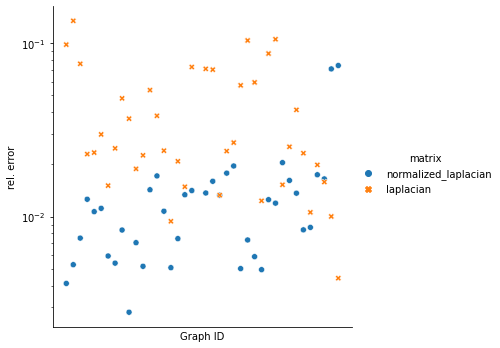

In [27]:
k = 4.5
tmp_df = df[df["k"]==k]
ax = sns.relplot(
    data=tmp_df,
    x="id", y="relative_error",
    hue="matrix", style="matrix"
)
ax.set(xlabel="Graph ID",ylabel="rel. error", yscale="log", xticks=[]) #
plt.savefig(f'plot/plot_each_graph_k{k}.png')
plt.show()